In [1]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from torchvision import datasets, transforms, models
import os
from torch import device

In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Define image transformations (preprocessing for CNN)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pretrained models
])

In [6]:
horizontal_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
vertical_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
random_rotatation_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomRotation(degrees=25), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [7]:
# Set up dataset and dataloaders
# Assuming images are organized in folders: 'root_folder/class1/', 'root_folder/class2/', etc.
data_dir = './maps_git/'  # Path to your image folder
train_data_1 = datasets.ImageFolder(root=data_dir, transform=horizontal_flip_transform)
train_data_2 = datasets.ImageFolder(root=data_dir, transform=vertical_flip_transform)
train_data_3 = datasets.ImageFolder(root=data_dir, transform=random_rotatation_transform)
train_data_4 = datasets.ImageFolder(root=data_dir, transform=transform)
augmented_dataset = ConcatDataset([train_data_1, train_data_2, train_data_3, train_data_4])
train_size = int(0.7 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - (train_size + val_size)
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size], generator=generator1)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [18]:
# Step 1: Load ResNet-50 model pre-trained on ImageNet
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

In [ ]:
# Step 1: Load ResNet-50 model pre-trained on ImageNet
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Step 2: Freeze all convolutional layers except the last convolutional layer (layer4)
# Freeze the entire model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last convolutional block (layer4)

for param in model.layer4.parameters():
    param.requires_grad = True

# Add global average pooling after the last convolutional block (layer4)
model.avgpool = nn.AdaptiveAvgPool2d(1)  # Add global average pooling layer to reduce the feature map to 1x1

# Now the model will have global average pooling followed by the fully connected layers
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 4),
)
model.to(device)
# Step 5: Print the modified model architecture to verify changes
print(model)

In [21]:
trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable Layers:", trainable_layers)

Trainable Layers: ['layer4.0.conv1.weight', 'layer4.0.bn1.weight', 'layer4.0.bn1.bias', 'layer4.0.conv2.weight', 'layer4.0.bn2.weight', 'layer4.0.bn2.bias', 'layer4.0.conv3.weight', 'layer4.0.bn3.weight', 'layer4.0.bn3.bias', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.1.conv1.weight', 'layer4.1.bn1.weight', 'layer4.1.bn1.bias', 'layer4.1.conv2.weight', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias', 'layer4.1.conv3.weight', 'layer4.1.bn3.weight', 'layer4.1.bn3.bias', 'layer4.2.conv1.weight', 'layer4.2.bn1.weight', 'layer4.2.bn1.bias', 'layer4.2.conv2.weight', 'layer4.2.bn2.weight', 'layer4.2.bn2.bias', 'layer4.2.conv3.weight', 'layer4.2.bn3.weight', 'layer4.2.bn3.bias', 'fc.1.weight', 'fc.1.bias']


In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 23516228


In [ ]:
%%time
num_epochs = 25

best_val_loss = float('inf')
patience = 10
counter = 0

# Store the results for each fold
fold_results = []

optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'weight_decay': 1e-4},
    {'params': model.fc.parameters(), 'weight_decay': 1e-4}
], lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

criterion = nn.CrossEntropyLoss()

# Track performance for this fold
fold_train_loss = []
fold_train_accuracy = []
fold_val_loss = []
fold_val_accuracy = []


for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    fold_train_loss.append(train_loss)
    fold_train_accuracy.append(train_accuracy)

    # Validation loop for this fold
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct / total * 100
    fold_val_loss.append(val_loss)
    fold_val_accuracy.append(val_accuracy)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'ResNet50_best.pth')
        print('The best model was saved.')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

In [26]:
def test_model(model, loader):
    model.eval()
    acc = 0.
    y_test, y_prediction =[], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            pred = logits.argmax(dim=1)
            acc += (pred == labels).sum().item()
            y_test.extend(labels.cpu().numpy())
            y_prediction.extend(pred.cpu().numpy())
    size = len(loader.dataset)
    acc = 100 * acc / size
    print(f'Test accuracy on {size} test samples is {acc:.2f}%')
    return y_test, y_prediction

In [27]:
class_names = {0: 'AA', 1: 'AI', 2: 'IA', 3: 'II'}
kept_classes = [0, 1, 2, 3]

In [28]:
def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

Test accuracy on 350 test samples is 76.00%


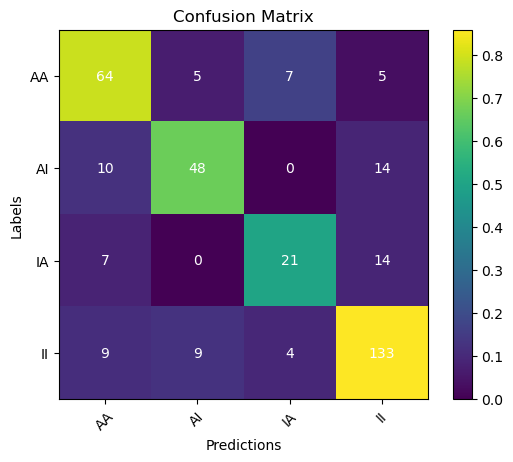

In [29]:
# Test the model
y_test, y_pred = test_model(model, test_loader)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, kept_classes)

In [30]:
classes = list(class_names.values())

In [31]:
print(classification_report(y_test, y_pred, target_names= classes))

              precision    recall  f1-score   support

          AA       0.71      0.79      0.75        81
          AI       0.77      0.67      0.72        72
          IA       0.66      0.50      0.57        42
          II       0.80      0.86      0.83       155

    accuracy                           0.76       350
   macro avg       0.74      0.70      0.72       350
weighted avg       0.76      0.76      0.76       350



In [ ]:
# Plot Training and Validation Loss/Accuracy
epochs = range(1, 14 + 1)

plt.figure(figsize=(12, 6))
# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, fold_train_loss, label="Training Loss", marker="o")
plt.plot(epochs, fold_val_loss, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, fold_train_accuracy, label="Training Accuracy", marker="o")
plt.plot(epochs, fold_val_accuracy, label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

print("Fine-tuning complete!")

In [ ]:
# Step 1: Load ResNet-50 model pre-trained on ImageNet
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Now the model will have global average pooling followed by the fully connected layers
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 4),
)
# Step 5: Print the modified model architecture to verify changes
print(model)

In [ ]:
#To load the saved weights into the model architecture:
model.load_state_dict(torch.load("ResNet50_best.pth")) 

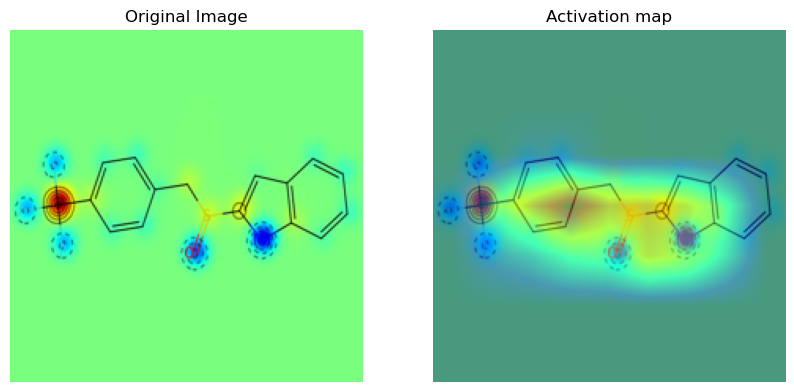

In [13]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Load Pre-trained ResNet50 and Set to Eval Mode
model.eval().to('cpu')

# 2. Define Grad-CAM Hook
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def get_cam(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)
        
        # If no target class, use the predicted class
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()
        
        # Backward pass to get gradients
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot)
        
        # Grad-CAM calculation
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.relu(cam)  # ReLU to keep positive influences
        cam = torch.nn.functional.interpolate(
            cam, size=input_image.shape[2:], mode='bilinear', align_corners=False
        )
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.squeeze().cpu().detach().numpy()

# 3. Preprocess Image
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return input_tensor, img

# 4. Generate Grad-CAM and Overlay Heatmap
def visualize_gradcam(img_path, target_class=None):
    # Preprocess
    input_tensor, original_img = preprocess_image(img_path)
    
    # Initialize Grad-CAM (target_layer = last convolutional layer)
    target_layer = model.layer4[-1].conv3  # For ResNet50
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM
    cam = grad_cam.get_cam(input_tensor, target_class)
    
    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Resize heatmap to match original image
    original_img = original_img.resize((224, 224))
    original_img = np.array(original_img)
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    
    # Overlay heatmap
    superimposed_img = heatmap * 0.4 + original_img * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Activation map")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 5. Run Grad-CAM on an Example Image
img_path = "./maps_git/II/fig_760.png"  # Replace with your image path
visualize_gradcam(img_path)